My previous naive implementation of transformer suffers the problem where 
its training task and evaluation task are very different. 

- During training, the transformer always gets fed with sequences with 60 timestep data.

- While evaluating, since we only provide the TF the initial condition, it needs to come up with a t1 data provided by just t0 data, for instance. Then at the second step, it needs to come up with [t1, t2] providing [t0, t1]. 

Therefore, the idea is that, for each input length, I will train a transformer model, using 
the exact same training data set. So that for each inference we are making, we make sure that
the training and evaluating have the same task.

Benefits:
- Highly parallelizable; the training in theory should not take 60 times the original time, since each model's training is completely independent from each other

Note that tf_id starts with 2; e.g. tf 2 predicts t1 state of the system

In [1]:
import torch, math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

### Data Preprocessing

In [2]:
theta_Tr = np.zeros(1)
theta_Te = np.zeros(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_save_model = 'save_model/'

def preproceess_data(NUM_DATA = 200, sanity_check = False):
    """
    NUM_DATA: how many data we want (number of different initial conditions)
    tf_id: the transformer that this dataset is prepared for (length of sequence for each initial condition)
    sanity_check: whether we are using the easy data (initial condition set to between -pi/10 to pi/10)
    """
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('../10pendula.npz')
    else:
        data = np.load('../10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
def preproceess_data_standardize(NUM_DATA, sanity_check = False):
    global theta_Tr, theta_Te
    # 1. Load the data from npz file
    if not sanity_check:
        data = np.load('../10pendula.npz')
    else:
        data = np.load('../10pendula_sanity_check.npz')
    for key, val in data.items():
        exec(key + '=val')
    og_theta = data['theta']
    # below prints the evolution of the position (angle) over time of the 2nd pendulum in the 121st sample
    # plt.plot(og_theta[:, 111, 3, 0])
    
    # 2. preproceses data to the dimension we want
    # now, there are NUM_DATA data entry (i.e. initial conditions), 
    # each has 60 timesteps, and each timestep is a vector of size 20 
    # each feature: [p0, v0, p1, v1, ... p19, v19]
    theta = np.transpose(og_theta, (1, 0, 2, 3)).reshape(50000, 60, 20)
    theta = theta[:NUM_DATA, :, :]
    N, _, _ = theta.shape
    cutoff = int(np.ceil(0.7 * N))
    theta_Tr = theta[:cutoff, :, :]
    theta_Te = theta[cutoff: , :, :]
    
    # 3. standardize the data by viewing position and velocity as 2 features
    pos_tr = theta_Tr[:,:,::2]
    vel_tr = theta_Tr[:,:,1::2]
    
    mean_std_dict = {
        "mean_pos": np.mean(pos_tr),
        "std_pos": np.std(pos_tr),
        "mean_vel": np.mean(vel_tr),
        "std_vel": np.std(vel_tr)
    }
    
    theta_Tr[:,:,::2] = (theta_Tr[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Tr[:,:,1::2] = (theta_Tr[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    theta_Te[:,:,::2] = (theta_Te[:,:,::2]  - mean_std_dict["mean_pos"]) / mean_std_dict["std_pos"] # position
    theta_Te[:,:,1::2] = (theta_Te[:,:,1::2]  - mean_std_dict["mean_vel"]) / mean_std_dict["std_vel"] # velocity
    
    return mean_std_dict

### TF and training 59 TF's

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, d_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model) # 1000^(2i/d_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/d_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/d_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        token_embedding = token_embedding.to(device)
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
class Transformer(nn.Module):
    # d_model : number of features
    def __init__(self,feature_size=20,num_layers=3,dropout=0):
        super(Transformer, self).__init__()
        self.positional_encoder = PositionalEncoding(d_model=feature_size, dropout=dropout, max_len=5000)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=5, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, device):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        output = self.positional_encoder(src)
        output = self.transformer_encoder(output,mask)
        output = self.decoder(output)
        return output

In [4]:
def train_one_transformer_teacher_forcing(tf_id, cur_theta_Tr, EPOCH = 200):
    # tf_id indicates which transformer it is
    model = Transformer().double().to(device)
    model.train()  # turn on train mode

    optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.MSELoss()
    best_model = ""
    min_train_loss = float('inf')
    
    for epoch in range(EPOCH + 1):
        train_loss = 0
        for i in range(cur_theta_Tr.shape[0]):
            # iterate through each training example
            cur_theta = cur_theta_Tr[i] # check dim later; not sure about batch
            optimizer.zero_grad()
            
            src = cur_theta[:-1,:] # input is the vector except for the last time step's
            src = torch.from_numpy(np.expand_dims(src, axis=1)).double().to(device) # torch.Size([59, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # this is the ground truth output, shift by one according to Medium blog post
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device) # torch.Size([59, 1, 20])
            
            prediction = model(src, device)
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            
        if train_loss < min_train_loss:
            torch.save(model.state_dict(), path_to_save_model + "best_train_" + str(tf_id) + f".pth")
#             torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer.pth")
            min_train_loss = train_loss
            
        if epoch % (np.ceil(EPOCH / 4)) == 0:
            print(f"Epoch: {epoch}, Average training loss: {train_loss / cur_theta_Tr.shape[0]}")

In [5]:
def train_fifty_nine_transformer_teacher_forcing(EPOCH = 200):
    """
    The output of this method is simply the fifty nine pth files in save_model/ folder
    """
    for tf_id in range(2, 61):
        cur_theta_Tr = theta_Tr[:, :tf_id, :] 
        print(cur_theta_Tr.shape)
        train_one_transformer_teacher_forcing(tf_id=tf_id, cur_theta_Tr=cur_theta_Tr, EPOCH=EPOCH)

### Evaluation and Visualization

In [21]:
def evaluate():
    """
    Now we simulate how we would use these tf in actual application.
    Given its initial condition, we feed it to tf_2, since it is trained to 
    predict inputs with sequences that have length 1. (predict t1' with t0)
    Then, using the t0 and t1', we use tf_3 to predict t2'.
    Then, using the t0, t1' and t2', we use tf_4 to predict t3'.
    Repeat until we have predicted t59'.
    """
    total_loss = 0
    criterion = torch.nn.MSELoss()
    loss_array = np.zeros(theta_Te.shape[0])
    
    with torch.no_grad():
        for i in range(theta_Te.shape[0]):
            # iterate through each testing data
            cur_theta = theta_Te[i]
            src = cur_theta[0,:] # t0, i.e. the only thing we will feed to our model
            src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
            target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
            target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)
            
            all_predictions = [] # records all predictions made by our models
            next_input_model = src # keeps track the input for next model
            
            for tf_id in range(2, 61):
                # get corresponding tf model and predict the (tf_id - 1)th timestamp
                model = Transformer().double().to(device)
                cur_model = path_to_save_model + "best_train_" + str(tf_id) + f".pth"
                model.load_state_dict(torch.load(cur_model)) 
                
                prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
                
                if all_predictions == []:
                    all_predictions = prediction # 1, 1, 20
                else:
                    all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))
                    
                next_input_model = all_predictions
                
            cur_loss = criterion(all_predictions, target).item()
            total_loss += cur_loss
            loss_array[i] = cur_loss
            
    return total_loss / theta_Te.shape[0], loss_array

In [16]:
def visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = False):
    """
    If want worst, will plot the test with the highest loss
    If want avg, will plot the test with the loss closest to the average
    """
    assert (want_worst + want_avg) == 1 # can only visualize one
    
    # 1. first locate the id that we want to visualize
    viz_id = -1
    if want_worst:
        viz_id = np.argmax(loss_array)
    elif want_avg:
        viz_id = np.argmin(np.abs(loss_array - average_testing_loss))
        
    # 2. rerun model for this test
    criterion = torch.nn.MSELoss()
    all_predictions = []
    cur_loss = 0
    
    with torch.no_grad():
        cur_theta = theta_Te[viz_id]
        src = cur_theta[0,:] # t0, i.e. the only thing we will feed to our model
        src = torch.from_numpy(np.expand_dims(src, axis=[0,1])).double().to(device) # torch.Size([1, 1, 20]) as 1 is batchsize
        target = cur_theta[1:,:] # shift by one according to Medium # t1 to 59
        target = torch.from_numpy(np.expand_dims(target, axis=1)).double().to(device)

        all_predictions = [] # records all predictions made by our models
        next_input_model = src # keeps track the input for next model

        for tf_id in range(2, 61):
            # get corresponding tf model and predict the (tf_id - 1)th timestamp
            model = Transformer().double().to(device)
            cur_model = path_to_save_model + "best_train_" + str(tf_id) + f".pth"
            model.load_state_dict(torch.load(cur_model)) 

            prediction = model(next_input_model, device) # torch.Size([j, 1, 20])
            if all_predictions == []:
                all_predictions = prediction # 1, 1, 20
            else:
                all_predictions = torch.cat((all_predictions, prediction[-1,:,:].unsqueeze(0)))

            next_input_model = all_predictions

        cur_loss = criterion(all_predictions, target).item()
            
    print("Average testing loss is: " + str(average_testing_loss))
    print("Visualizing test with loss: " + str(cur_loss))
    target = theta_Te[viz_id, 1:]
    prediction = torch.squeeze(all_predictions).cpu()
    
    # 3. first plot position
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 200, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 # since we only want the position features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Position')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Position Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. then plot velocity
    fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = [10,8], dpi = 100, sharex=True, sharey=True)
    for i_loop in range(10):
        i = i_loop * 2 + 1 # since we only want the velocity features
        plt.sca(axs.flatten()[i_loop])
        plt.plot(target[:,i], '.-', lw = 1, c = 'k', alpha = 0.5, label = 'ground truth')
        plt.plot(prediction[:,i], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'NN prediction')
        plt.xlabel('Timestep')
        plt.ylabel('Velocity')
        plt.title(f'Pendulum {i_loop}')
        plt.grid()
    fig.suptitle("Velocity Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
mean_std_dict = preproceess_data_standardize(NUM_DATA = 500, sanity_check = False)

In [11]:
train_fifty_nine_transformer_teacher_forcing(EPOCH = 300)

(350, 2, 20)
Epoch: 0, Average training loss: 0.7814589853248838
Epoch: 75, Average training loss: 0.014659256045565557
Epoch: 150, Average training loss: 0.005858341860188513
Epoch: 225, Average training loss: 0.005219472445192649
Epoch: 300, Average training loss: 0.006113742395377798
(350, 3, 20)
Epoch: 0, Average training loss: 0.6847347608615713
Epoch: 75, Average training loss: 0.0465631324838336
Epoch: 150, Average training loss: 0.03734243794510586
Epoch: 225, Average training loss: 0.019057577465454736
Epoch: 300, Average training loss: 0.010141492468895843
(350, 4, 20)
Epoch: 0, Average training loss: 0.6862543266898002
Epoch: 75, Average training loss: 0.03179407529144566
Epoch: 150, Average training loss: 0.018609730374303732
Epoch: 225, Average training loss: 0.015097605742020504
Epoch: 300, Average training loss: 0.013454847514959614
(350, 5, 20)
Epoch: 0, Average training loss: 0.7168148977884335
Epoch: 75, Average training loss: 0.03802920337922544
Epoch: 150, Average t

In [23]:
average_testing_loss, loss_array = evaluate()

Average testing loss is: 0.9315604309455405
Visualizing test with loss: 0.9335291800848701


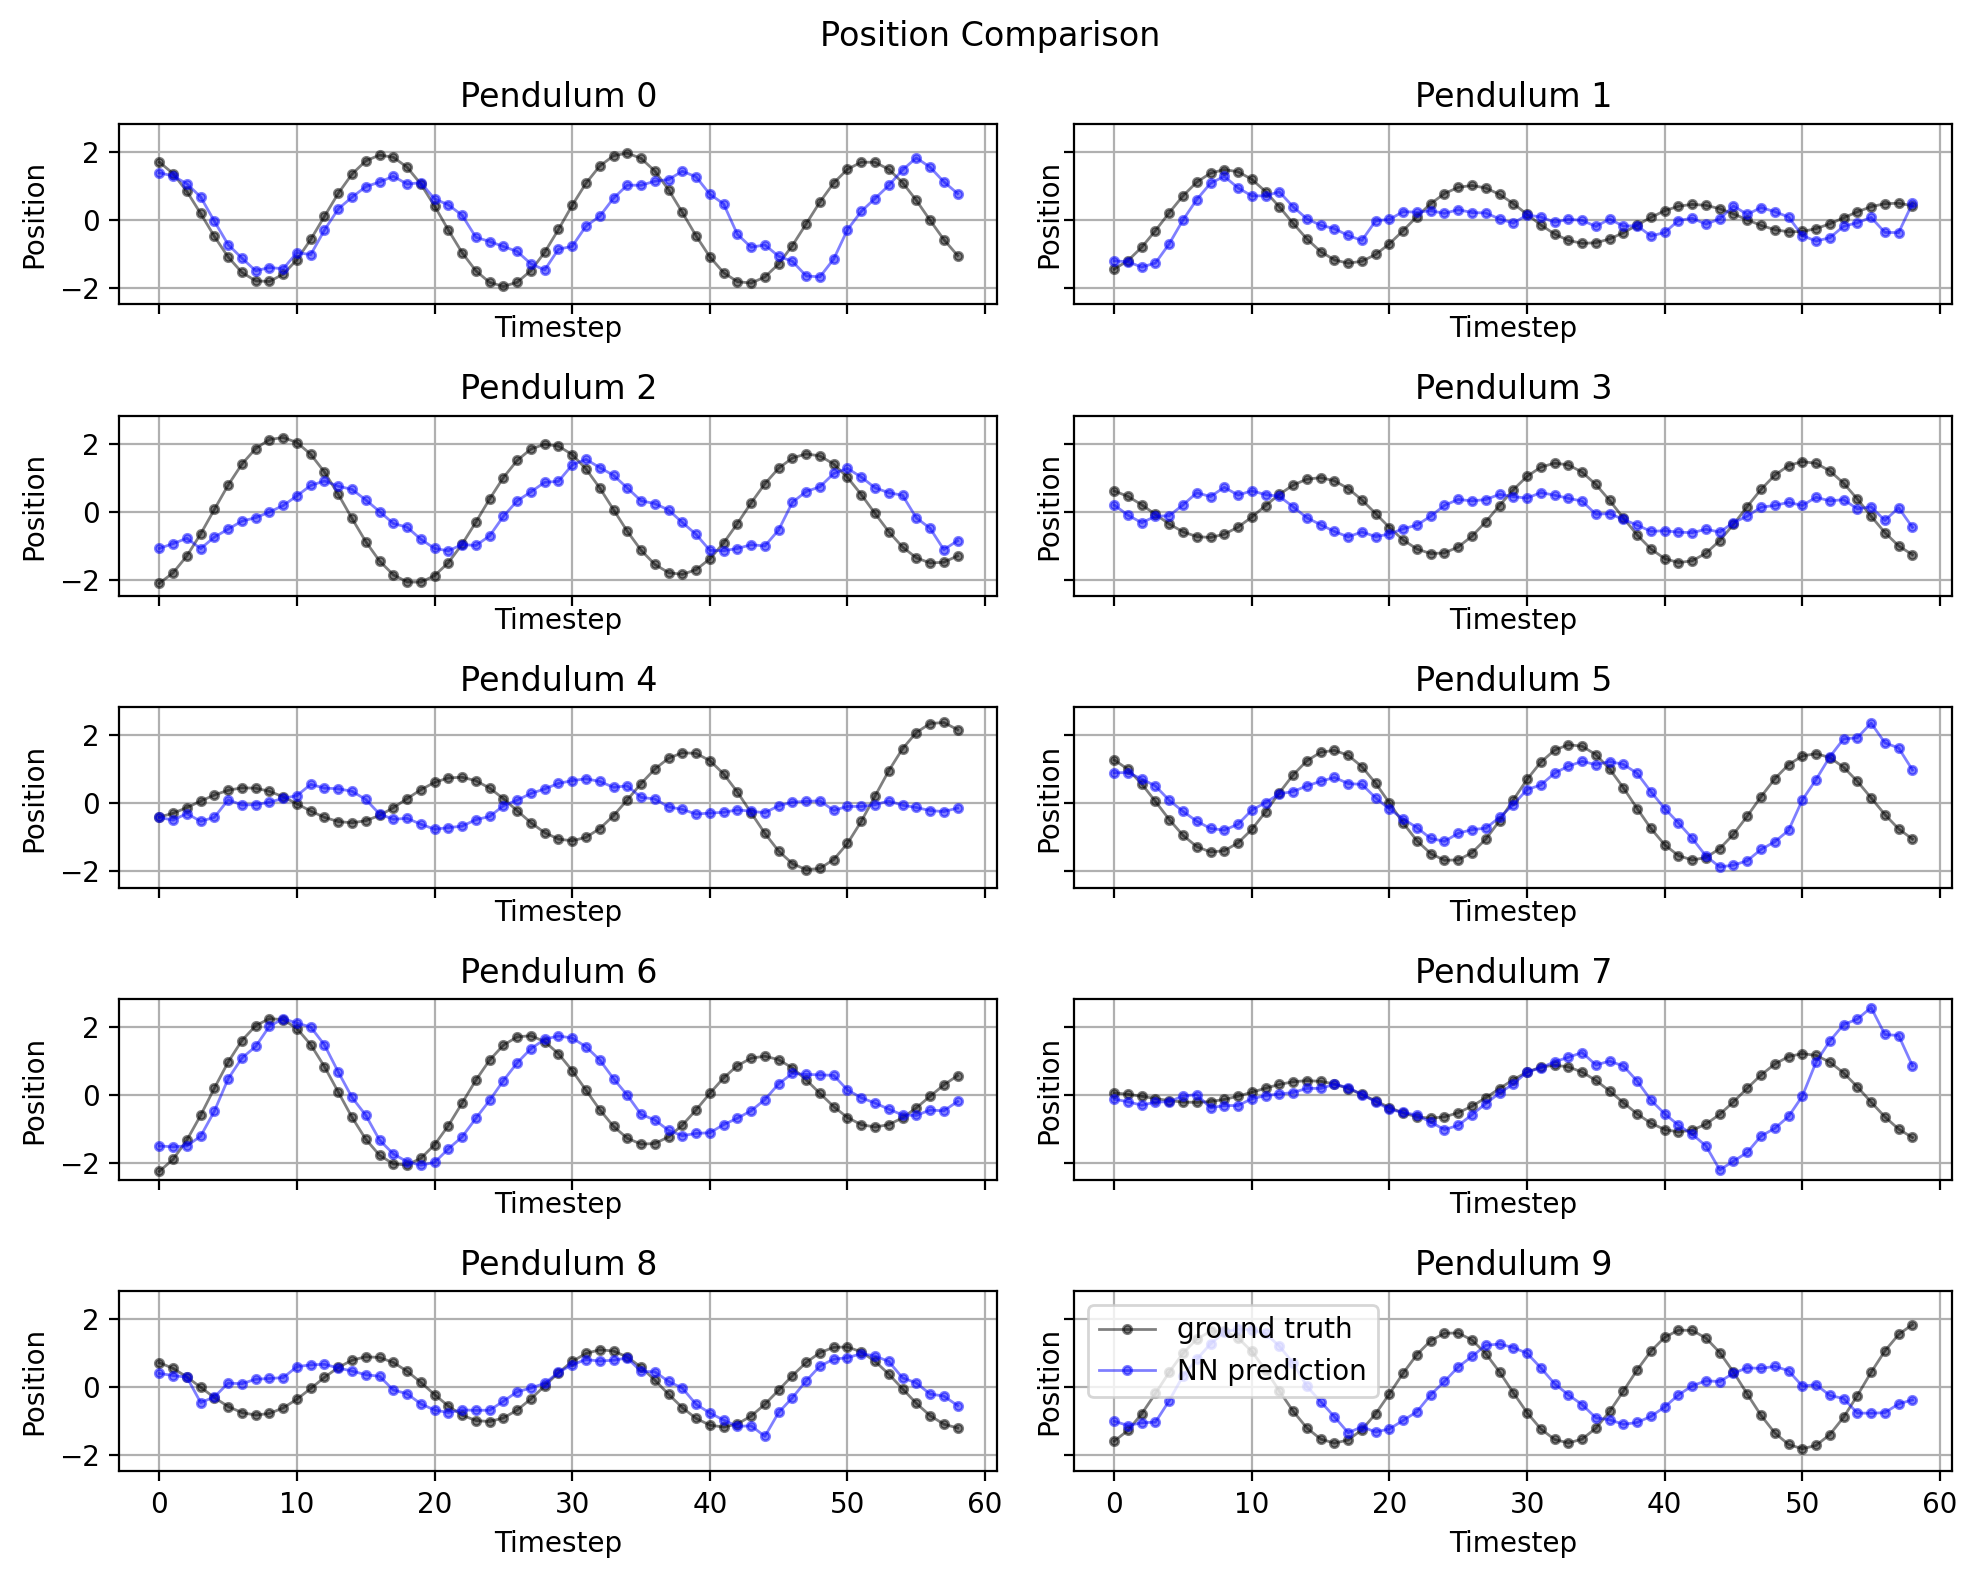

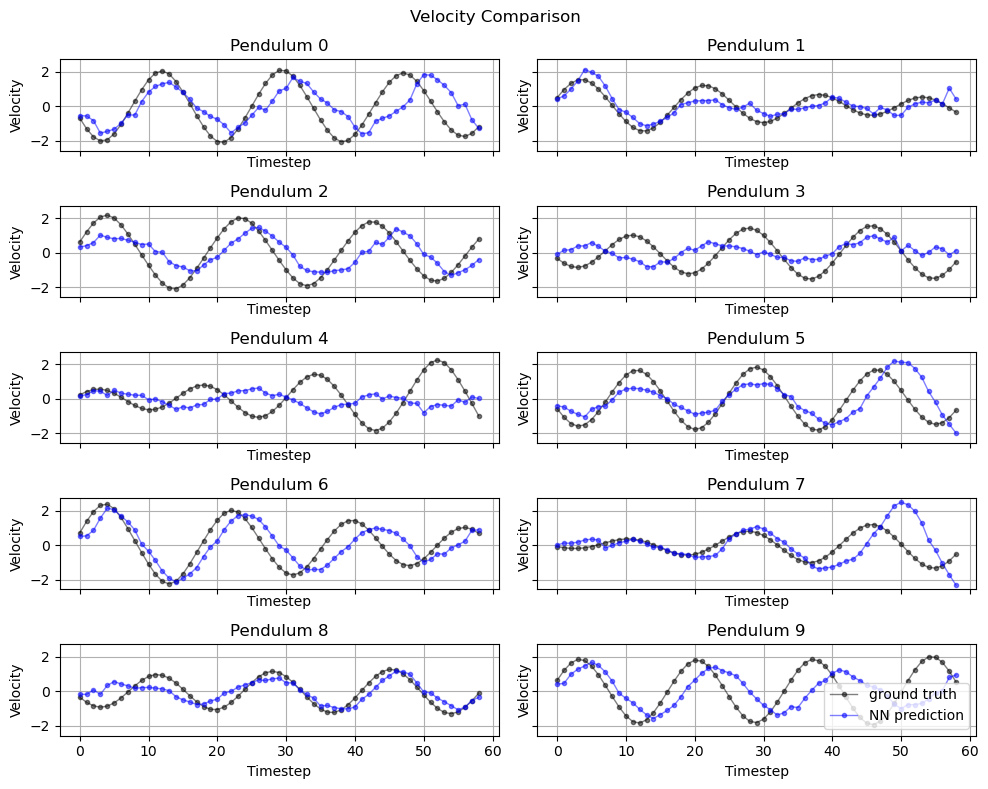

In [24]:
visualize_test(loss_array, average_testing_loss, want_worst = False, want_avg = True)